# ICPアルゴリズム
Iterative Closest Points　(ICP)アルゴリズムは，点群同士の位置合わせ処理に広く用いられる大変有名なアルゴリズムです．
位置合わせ元となるソース点群と位置合わせ先であるターゲット点群を入力とし，
ソース点群をターゲット点群に位置合わせするために必要な回転と並進（まとめて剛体変換と表記します）を推定します．
ICPアルゴリズムで位置合わせ結果に精密さを求めるケースにおいて特に効果を発揮します．
また，ICPは初期値依存性のあるアルゴリズムです．ソース点群とターゲット点群がある程度近い状態でないと，良い解を得られません．
ソース点群とターゲット点群が大きくずれている場合には，例えば，第5章で説明するキーポイントマッチングによる姿勢推定によって（粗い）位置合わせを行っておき，
これをICPアルゴリズムで扱うソース点群の初期姿勢とします．


ICPアルゴリズムは次の４つの操作で構成されるアルゴリズムです．
- Step 1. ソース点群とターゲット点群の対応付け
- Step 2. 剛体変換の推定
- Step 3. 物体の姿勢のアップデート
- Step 4. 収束判定（収束しない場合は1.へ戻る）

このステップを繰り返すことによって，ソース点群をターゲット点群に徐々に近づけながら剛体変換を推定します．

本章では，Open3Dを使ったICPの実行方法と，Point-to-point，Point-to-planeの２種類のタイプのICPアルゴリズムの実装方法を解説します．


## Open3DによるICPの実行
Open3DにはICPアルゴリズムが実装されているので数行のコードで実行することが可能です．
まずは動作させてみましょう．

In [6]:
import open3d as o3d
import numpy as np
import copy


pcd1 = o3d.io.read_point_cloud( "data/bun000.pcd" )
pcd2 = o3d.io.read_point_cloud( "data/bun045.pcd" )

pcd_s = pcd1.voxel_down_sample(voxel_size=0.005)
pcd_t = pcd2.voxel_down_sample(voxel_size=0.005)

ソース点群$P$を変数名```pcd_s```，ターゲット点群$X$を変数名```pcd_t```としてデータを用意します．
可視化結果をわかりやすくするために，点群をvoxel_down_sample（第\ref{sec:voxel_down_sampling}節参照）によって間引いています．

初期状態を表示させてみましょう．

In [3]:
pcd_s.paint_uniform_color([0.0, 1.0, 0.0])
pcd_t.paint_uniform_color([0.0, 0.0, 1.0])
o3d.visualization.draw_geometries([pcd_s,pcd_t])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


ソース点群を緑，ターゲット点群を青に着色しています．

ICPアルゴリズムの実行には```o3d.pipelines.registration.registration_icp```を使います．
関数の引数は以下の通りです．
- pcd_s：位置合わせ元の点群です．この点群の姿勢をアップデートします．
- pcd_t：位置合わせ先の点群です．
- threshold：２つの点群を対応付けするときの最大距離です．
- trans_init：pcd_sの初期姿勢です．今回は，単位行列（＝pcd_sの姿勢変換なし）を初期姿勢としました．
- obj_func：目的関数（後述）の選択肢です．

位置合わせの結果は```result```に保存されています．確認しましょう．

In [4]:
threshold = 0.05
trans_init = np.identity(4)
obj_func = o3d.pipelines.registration.TransformationEstimationPointToPoint()
result = o3d.pipelines.registration.registration_icp( pcd_s, pcd_t,
                                                      threshold,
                                                      trans_init,
                                                      obj_func
                                                    )

In [5]:
trans_reg = result.transformation
print(trans_reg)

[[ 8.67034091e-01  4.49992090e-02 -4.96212613e-01  3.36439339e-02]
 [-3.08211182e-02  9.98849925e-01  3.67271928e-02 -4.14622696e-04]
 [ 4.97294625e-01 -1.65499006e-02  8.67423862e-01  4.06317347e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


trans_regは次の4x4の同次変換行列です．
$ {\bf T} = \left[
    \begin{array}{cc}
      R & {\bf t} \\
      {\bf 0} & 1 \\
    \end{array}
  \right]$
  
$\bf R$は3x3回転行列，$\bf t$は3次元平行移動ベクトルです．

変換後のソース点群を```pcd_reg```を赤に着色して，結果を可視化してみましょう．

In [5]:
# 得られた変換行列を点群に適用
pcd_reg = copy.deepcopy(pcd_s).transform(trans_reg)

pcd_reg.paint_uniform_color([1.0, 0.0, 0.0])
o3d.visualization.draw_geometries([pcd_reg,pcd_t])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


図の通り，変換後のソース点群（赤）がターゲット点群（青）によく一致していることがわかります．

## ICPアルゴリズムの目的関数
ICPアルゴリズムはStep2において，Point-to-point，Point-to-planeと呼ばれる２種類の目的関数のいずれかを最小化する剛体変換を推定します．

Point-to-pointはBeslとMckayによって発表されたICPアルゴリズムの原著論文で使われている目的関数です．

$E({\bf T}) = \sum_{({\bf x},{\bf p})\in \mathcal{K}}({\bf x}-{\bf Tp})^2$

$\mathcal{K}$は，Step1で求めた対応点の集合です．
${\bf x},{\bf p}$はそれぞれ$X, P$の点です．
この関数では，剛体変換$T$を適用した点$\bf p$とその対応点である$\bf x$との距離を評価しています．
このように，対応点間の二乗距離を使って距離を求めているので，この目的関数はPoint-to-pointと呼ばれています．
Open3Dでは，```obj_func```を以下のように設定することによって，point-to-pointの目的関数を利用することができます．
``` python
obj_func = o3d.pipelines.registration.TransformationEstimationPointToPoint()
```
Point-to-planeは，ソースの点とターゲットの面の距離を評価する目的関数です．

$E({\bf T}) = \sum_{({\bf x},{\bf p})\in \mathcal{K}}(({\bf x}-{\bf Tp})\cdot{\bf n_x})^2$

$\bf n_x$は点$\bf x$の法線ベクトルです．
$\bf x$を通る法線$\bf n_x$の平面を仮定し，その平面と$\bf p$間の距離を最小化することによって，剛体変換を求めます．
多くの場合でPoint-to-pointのICPよりも少ない繰り返し回数で繰り返し演算が収束することが知られています．しかしながら，法線付きの点群を扱わなければならないことに注意しましょう．
```o3d_icp.py```の20行目にある```obj_func```を以下のように設定することによって，point-to-planeの目的関数を利用することができます．
``` python
obj_func = o3d.pipelines.registration.TransformationEstimationPointToPlane()
```

Open3Dを使ってICPアルゴリズムを動作させるときは，このように1行だけ変更するだけでよいのですが，
上記の２つの目的関数は，同一の解き方で剛体変換を算出することができません．
次章から，それぞれの目的関数ごとに実装方法を解説します．

# ICPアルゴリズムの実装（Point-to-point）
前述した通り，Open3Dを使うことによって，ICPアルゴリズムの動作を確認することができます．
ここでは，アルゴリズムの内部を理解するために，Pythonコードとして実装してみます．
実装する内容は原著論文[1] に従います．
論文によると，ICPの手順は以下の4ステップです．
- Step 1. ソース点群とターゲット点群の対応付け
- Step 2. 剛体変換の推定
- Step 3. 物体の姿勢のアップデート
- Step 4. 収束判定（収束しない場合は1.へ戻る）

以下では，このステップごとに実装します．まずは点群を読み込みます．まずは位置合わせ対象の点群を読み込みます．先ほどと同様，ソース点群$P$を変数名```pcd_s```，ターゲット点群$X$を変数名```pcd_t```としてデータを用意し，初期状態を可視化します．

[1] Paul J Besl and Neil D McKay, Method for registration of 3-D shapes, IEEE Trans on PAMI, Vol.14, No.2, pp.239-256, 1992.

In [11]:

import open3d as o3d
import numpy as np
import numpy.linalg as LA
import copy

pcd1 = o3d.io.read_point_cloud( "data/bun000.pcd" )
pcd2 = o3d.io.read_point_cloud( "data/bun045.pcd" )

pcd_s = pcd1.voxel_down_sample(voxel_size=0.005)
pcd_t = pcd2.voxel_down_sample(voxel_size=0.005)

pcd_s.paint_uniform_color([0.0, 1.0, 0.0])
pcd_t.paint_uniform_color([0.0, 0.0, 1.0])
o3d.visualization.draw_geometries([pcd_t, pcd_s] )

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


さて，論文で紹介されたICPアルゴリズムでは，物体の姿勢を同次変換行列ではなく，７つの実数値で表されるレジストレーションベクトル${\bf q}$として扱います．
これは，ICPアルゴリズムにおける姿勢計算において，Hornによって提案された手法 --単位四元数を用いて対応の取れた点群同士の位置ずれ誤差を最小化する位置姿勢を計算するアルゴリズム[2]-- を適用するためです．

[2]
B. Horn, "Closed-form solution of absolute orientation using unit quaternions," J. Opt. Soc. Am. A  4, 629-642 (1987).

${\bf q}$の最初の4つの実数値${\bf q}_R = [q_0 q_1 q_2 q_3]^T$は回転成分を表現する単位四元数であり，
$q_0 \geq 0$かつ$q_0^2+q_1^2+q_2^2+q_3^2=1$です．
四元数から，3x3回転行列への変換は以下とおりです．


\begin{equation}
{\bf R} = \left[
    \begin{array}{ccc}
      q_0^2+q_1^2-q_2^2-q_3^2 & 2(q_1q_2-q_0q_3) & 2(q_1q_3+q_0q_2)\\
      2(q_1q_2+q_0q_3) & q_0^2+q_2^2-q_1^2-q_3^2 & 2(q_2q_3-q_0q_1)\\
      2(q_1q_3-q_0q_2) & 2(q_2q_3+q_0q_1) & q_0^2+q_3^2-q_1^2-q_2^2\\
    \end{array}
  \right]
\end{equation}

点群を剛体変換させるときは4x4同次変換行列を使うと楽なので，四元数は上記の式を使って回転行列に変換します．
後半の3つの実数値${\bf q}_t = [q_4 q_5 q_6]^T$は平行移動ベクトルです．


原著論文のICPアルゴリズムは，レジストレーションベクトルを使って以下の目的関数を最小化します．

\begin{equation}
f({\bf q}) = \frac{1}{N}\sum_{i=1}^{N}||{\bf x_i} - {\bf R}({\bf q}_R){\bf p}_i - {\bf q}_t||
\end{equation}

ここで，${\bf R}({\bf q}_R)$は，四元数${\bf q}_R$を回転行列に変換する関数です．
まず，レジストレーションベクトルを初期化します．

\begin{equation}
{\bf q} = (1, 0, 0, 0, 0, 0, 0)
\end{equation}

ICPアルゴリズムでは，この${\bf q}$の値をアップデートしながら，ソースをターゲットに位置合わせする剛体変換を算出します．
${\bf q}$の初期化と四元数から回転行列への変換は以下の通りに実装します．

In [12]:
def quaternion2rotation( q ):
    rot = np.array([[q[0]**2+q[1]**2-q[2]**2-q[3]**2, 
                     2.0*(q[1]*q[2]-q[0]*q[3]), 
                     2.0*(q[1]*q[3]+q[0]*q[2])],
                    
                    [2.0*(q[1]*q[2]+q[0]*q[3]),
                    q[0]**2+q[2]**2-q[1]**2-q[3]**2,
                     2.0*(q[2]*q[3]-q[0]*q[1])],
                    
                    [2.0*(q[1]*q[3]-q[0]*q[2]),
                     2.0*(q[2]*q[3]+q[0]*q[1]),
                    q[0]**2+q[3]**2-q[1]**2-q[2]**2]]
                  )
    return rot

q = np.array([1.,0.,0.,0.,0.,0.,0.])
rot = quaternion2rotation(q)
print(rot)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


初期値の$\bf q$は回転行列に変換すると単位行列になります．つまり，点群を回転させないことを意味します．

## Step 1. 最近傍点探索

Step1を実装しましょう．このステップの目的は，ソース点群$P_k$の各点の対応点をターゲット$X$から探すことです．$X$の点数は$P$と一致していなくても構いません．
見つかった対応点の集まりを$Y_k$とします．
$k$はICPアルゴリズムの各ステップの繰り返し回数で,$P_k, Y_k$の点数$N$は同一です．
$Y_k$に登録される点は重複することがありますが，これを許します．


ここで，2点のユークリッド距離を$d({\bf r}_1, {\bf r}_2)$とします．この表記を拡張し，
特定の点$p$と，点数$N_a$で構成される点群$A = \{{\bf a}_i\}, i=1,...,N_a$の距離を以下で定義します．

\begin{equation}
d({\bf p}, A) =  \min_{ i \in \{1,...N_a\} } d({\bf p}, {\bf a}_i)
\end{equation}

このステップでは，$P_k$に含まれる全点に対して$X$との最近傍点を取り出し，これを対応点セット$Y_k$とします．
この処理を

\begin{equation}
Y_k = C(P_k,X)
\end{equation}
と表記します．
簡単には全数探索すればよいのですが，時間がかかりますので，kd-treeによる最近傍点探索として実装します．

In [13]:
pcd_tree = o3d.geometry.KDTreeFlann(pcd_t)

idx_list = []
for i in range(len(pcd_s.points)):
    [k, idx, _] = pcd_tree.search_knn_vector_3d(pcd_s.points[i], 1)
    idx_list.append(idx[0])

np_pcd_t = np.asarray(pcd_t.points)
np_pcd_y = np_pcd_t[idx_list].copy()

ICPアルゴリズムの処理のループ中では，多くの回数のターゲット点群に対する最近傍探索を実施しますので，あらかじめkd-treeを構築しておきます(1行目)．

2行目以降では，ソースの点群を１点ずつクエリとして，最近傍点のインデクスをリストとして取り出す処理を実行します．

ここで一旦，対応点セット$Y_k$を確認してみましょう．対応点を線で結んで表示します．

In [14]:
def GetCorrespondenceLines( pcd_s, pcd_t, idx_list ):
    
    # make point cloud pair
    np_pcd_s = np.asarray(pcd_s.points)
    np_pcd_t = np.asarray(pcd_t.points)
    np_pcd_pair = np.concatenate((np_pcd_s,np_pcd_t))

    # choose pairing ids
    lines = list()
    n_points = len(pcd_s.points)
    for i in range(n_points):
        lines.append([i,n_points+idx_list[i]])

    # make lineset    
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(np_pcd_pair),
        lines=o3d.utility.Vector2iVector(lines),
    )
    return line_set

line_set = GetCorrespondenceLines( pcd_s, pcd_t, idx_list )
o3d.visualization.draw_geometries([pcd_s,pcd_t,line_set])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


関数```GetCorrespondenceLines```では，ソース点群，ターゲット点群，ソースに対するターゲットの対応点のインデクスリストの３つを入力として，Open3Dで可視化可能なLineSetを作成します．

緑がソース点群，青がターゲット点群です．ソース点群からターゲットの最近傍探索を実施したので，各緑点に対して最も近い青点が線で結ばれています．

## Step 2. 剛体変換の推定
事前にソース点群とターゲット点群の重心がゼロに合わせられているとする（並進成分は考えなくて良い状態）と，今回の問題は次の式を最大化する$R$を求める問題といえます．

\begin{equation}
\sum^{n}_{i=0}{\bf y_i}\cdot R{\bf p_i}
\end{equation}

これは，回転行列$R$を構成する9個の成分を変数とした連立方程式といえます．
簡単に解くことができそうですが，問題はそう単純ではありません．
$R$は回転行列なので，行列の要素の直交性を保証しつつ，上式を最大化する$R$を見つける必要があります．
Horn\cite{Horn1987}は，上式を次のように単位四元数によって扱うと，回転行列の条件を満たした$R$が得られることを示しました．

\begin{equation}
\sum^{n}_{i=0}(qp_iq^{*}) \cdot y_i
\end{equation}

これを，見通しが良くなるように変形します．

\begin{equation}
\sum^{n}_{i=0}(qp_iq^{*}) \cdot y_i = \sum^{n}_{i=0}(qp_i)\cdot(y_iq) = \sum^{n}_{i=0}(\bar{P}_i q)\cdot(\bar{Y}_i q)
\end{equation}

4x4行列$\bar{P}_i , \bar{Y}_i$は四元数の積のための行列表記です．さらに，シグマに関係のある部分をまとめるように式変形します．

\begin{equation}
\sum^{n}_{i=0}(\bar{P}_i q)\cdot(\bar{Y}_i q) = \sum^{n}_{i=0} q^{T}\bar{P}_i^{T} \bar{Y}_i q = q^{T}(\sum^{n}_{i=0}\bar{P}_i^{T} \bar{Y}_i)q = q^{T}(\sum^{n}_{i=0}N_i)q = q^{T}N_{py}q
\end{equation}

このように，目的関数は回転行列を表す単位四元数$q$と4x4行列$N$の積で表すことができました．
ここで，行列$N$について考えます．

まず，
\begin{equation}
N_i = \bar{P}_i^{T} \bar{Y}_i = \begin{pmatrix}0&p_{x,i}&p_{y,i}&p_{z,i}\\-p_{x,i}&0&-p_{z,i}&p_{y,i}\\-p_{y,i}&p_{z,i}&0&-p_{x,i}\\-p_{z,i}&-p_{y,i}&p_{x,i}&0\end{pmatrix}\begin{pmatrix}0&-y_{x,i}&-y_{y,i}&-y_{z,i}\\y_{x,i}&0&-y_{z,i}&y_{y,i}\\y_{y,i}&y_{z,i}&0&-y_{x,i}\\y_{z,i}&-y_{y,i}&y_{x,i}&0\end{pmatrix}
\end{equation}
となるので，$N_{py}$については，
\begin{equation}
N_{py} = \sum^{n}_{i=0} N_i  = 
\begin{pmatrix} 
(s_{xx}+s_{yy}+s_{zz}) & s_{yz}-s_{zy} & s_{zx}-s_{xz} & s_{xy}-s_{yx} \\
 s_{yz}-s_{zy} & (s_{xx}-s_{yy}-s_{zz}) & s_{xy}+s_{yx} & s_{xz}+s_{zx} \\
 s_{zx}-s_{xz} & s_{xy}+s_{yx} & (-s_{xx}+s_{yy}-s_{zz}) & s_{yz}+s_{zy} \\
 s_{xy}-s_{yx} & s_{zx}+s_{xz} & s_{yz}+s_{zy} & (-s_{xx}-s_{yy}+s_{zz}) \\
\end{pmatrix}
\end{equation}
と書くことができます．
ここで，行列の各成分は例えば，
\begin{equation}
s_{xx} = \sum p_{x,i}y_{x,i}, 　　　s_{xy} = \sum p_{x,i}y_{y,i}
\end{equation}
であり，２つの点群の分散共分散行列を$S_{py}$で表すとすると，その成分になっていることが分かります．

結局のところ，今回の問題は$q^{T}N_{py}q$を最大化する単位四元数を考えれば良いことになります．
これは，対称行列$N_{py}$の最大固有値に対する固有ベクトルです．固有ベクトルは単位ベクトルですから，位置ずれ誤差を最小化する単位四元数ということになります．



それでは，実装に入りましょう，ソース点群とターゲット点群から対称行列$N_{py}$を計算し，固有値問題を解きます．
はじめに，$N_{py}$の構成要素である，分散共分散行列を算出します．

上記では，２つの点群の重心がゼロに合わせられている前提で説明していましたので，重心を考慮した計算を行います．
まず，2つの点群$P_k, Y_k$の重心を算出します．

\begin{equation}
\vec{\mu}_p = \frac{1}{N}\sum_{i=1}^{N}{\bf p}_i , \vec{\mu}_y = \frac{1}{N}\sum_{i=1}^{N}{\bf y}_i 
\end{equation}

重心位置は，点群を```open3d.geometry.PointCloud```で扱っているときは```get_center()```で取り出すことが出来ますが，後々の計算の都合で，点群データをnumpy配列に変換してから重心を計算します．

In [15]:
np_pcd_s = np.asarray(pcd_s.points)

mu_s = np_pcd_s.mean(axis=0)
mu_y = np_pcd_y.mean(axis=0)

次に以下の式で表す共分散行列$S_{py}$を計算します．
\begin{equation}
S_{py} = \frac{1}{N}\sum_{i=1}^{N}[({\bf p}_i-\vec{\mu}_p)({\bf y}_i-\vec{\mu}_y)^T] = \frac{1}{N}\sum_{i=1}^{N}[{\bf p}_i{\bf y}_i^T]-\vec{\mu}_p\vec{\mu}_y^T
\end{equation}

In [24]:
np_pcd_s = np.asarray(pcd_s.points)
covar = np.zeros( (3,3) )
n_points = np_pcd_s.shape[0]
for i in range(n_points):
    covar += np.dot( np_pcd_s[i].reshape(-1, 1), np_pcd_y[i].reshape(1, -1) )
covar /= n_points
covar -= np.dot( mu_s.reshape(-1,1), mu_y.reshape(1,-1) )
print(covar)

[[ 1.37394406e-03 -4.77765288e-04  4.27147885e-04]
 [-4.39511841e-04  1.45899051e-03 -5.57556349e-04]
 [-1.42891587e-05 -4.82877488e-04  3.24402804e-04]]


$S_{py}$を元に，4x4の対称行列$N_{py}$を作成します．
実は，$N_{py}$の構成要素は次のように表すことができます．

\begin{equation}
N_{py} = \left[
    \begin{array}{cc}
      tr(S_{py}) & \Delta^T \\
      \Delta & S_{py}+S_{py}^T-tr(S_{py})I_3\\
    \end{array}
  \right]
\end{equation}

$tr(S_{py})$は$S_{py}$の対角成分の総和，
$\Delta = [A_{12} A_{31} A_{12}]^T$は$A_{ij} = (S_{py}-S_{py}^T)_{ij}$で構成されるベクトル，
$I_3$は3x3単位行列です．
このように表現すると，実装がすっきりします．

In [25]:
A = covar - covar.T
delta = np.array([A[1,2],A[2,0],A[0,1]])
tr_covar = np.trace(covar)
i3d = np.identity(3)

N_py = np.zeros((4,4))
N_py[0,0] = tr_covar
N_py[0,1:4] = delta
N_py[1:4,0] = delta
N_py[1:4,1:4] = covar + covar.T - tr_covar*i3d
print(N_py)

[[ 3.15733737e-03 -7.46788609e-05 -4.41437044e-04 -3.82534475e-05]
 [-7.46788609e-05 -4.09449245e-04 -9.17277129e-04  4.12858726e-04]
 [-4.41437044e-04 -9.17277129e-04 -2.39356364e-04 -1.04043384e-03]
 [-3.82534475e-05  4.12858726e-04 -1.04043384e-03 -2.50853177e-03]]


$N_{py}$の最大固有値に対する固有ベクトルが${\bf q}_R = [q_0 q_1 q_2 q_3]^T$に対応します．
固有値の計算は```np.linalg.eig()```に任せます．
```w```は固有値，```v```が固有ベクトルです．
```v```において，最大固有値のインデクスの列成分が${\bf q}_R$，すなわち位置ずれ誤差最小化する回転を表す単位四元数です．取り出して回転行列に変換しましょう．

In [19]:
w, v = LA.eig(N_py)
rot = quaternion2rotation(v[:,np.argmax(w)])
print("Eigen value\n",w)
print("Eigen vector\n",v)
print("Rotation\n", rot)

Eigen value
 [ 0.00321629  0.00089154 -0.00118716 -0.00292066]
Eigen vector
 [[ 0.9902867  -0.11590601 -0.06993114  0.03174401]
 [ 0.0163969   0.61149657 -0.7908013  -0.02089016]
 [-0.13669921 -0.72411763 -0.57227222  0.35982147]
 [ 0.01940921  0.2971387   0.20554184  0.93224698]]
Rotation
 [[ 0.96187322 -0.04292425 -0.27010632]
 [ 0.03395848  0.99870885 -0.03778171]
 [ 0.27137932  0.02716882  0.96208893]]


並進成分は以下の式で計算できます．
\begin{equation}
{\bf q}_t = \vec{\mu}_y - {\bf R}({\bf q}_R)\vec{\mu}_p
\end{equation}

In [21]:
trans = mu_y - np.dot(rot,mu_s)

## Step 3. 物体の姿勢のアップデート
ここまででレジストレーションベクトル$\bf q$がわかりました．実際に点群を剛体変換させるときは4x4同次変換行列にすることによって，```transform```で変換することができます．

In [22]:
transform = np.identity(4)
transform[0:3,0:3] = rot.copy()
transform[0:3,3] = trans.copy()
print("Transformation\n", transform)

Transformation
 [[ 0.96187322 -0.04292425 -0.27010632  0.01846238]
 [ 0.03395848  0.99870885 -0.03778171  0.00425928]
 [ 0.27137932  0.02716882  0.96208893  0.01264089]
 [ 0.          0.          0.          1.        ]]


この変換行列を使えばソース点群はターゲット点群に近づくはずです．可視化してみましょう．
今回の変換で作成する点群は赤にします．

In [23]:
pcd_s2 = copy.deepcopy(pcd_s) 
pcd_s2.transform(transform)
pcd_s2.paint_uniform_color([1.0,0.0,0.0])
o3d.visualization.draw_geometries([pcd_t, pcd_s, pcd_s2] )

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


もともとの緑の点群が変換され，位置合わせ対象の青の点群に近づいていることがわかります．

後は，```pcd_s2```を$P_{k}$として，終了条件を満たすまでStep1-Step3を繰り返します．
終了条件には以下のものがよく使われます．
- ソース点群とターゲット点群の二乗誤差がしきい値以下になる
- 指定しておいた最大の繰り返し回数に到達する
- k-1番目とk番目の剛体変換の差が少ない

最初の条件は，あらかじめ決めた位置合わせ誤差以内に収束したかどうかをチェックすることができるので，
この条件に当てはまって繰り返し演算が終了したときは，位置合わせが成功したことになります．
残りの２つの条件は，決められた回数内での繰り返し演算で，位置合わせ誤差が十分小さくならなかった場合や，
位置合わせ誤差の改善が起きなかった場合に該当します．
この条件に当てはまって終了した場合は，所望の結果が得られたのかどうかを確認する必要があります．


ここまでの処理を一つのクラスとして実装したサンプルコードは```icp_registration.py```です．
このクラスを利用してICPをおこなうサンプルコードの実行方法は次の通りです．第一引数に0を指定してください．

``` bash
python run_my_icp.py 0
```

```run_my_icp.py```で重要なのは以下の部分です．
``` python
reg = ICPRegistration_PointToPoint(pcd_s, pcd_t)
reg.set_th_distance( 0.003 )
reg.set_n_iterations( 100 )
reg.set_th_ratio( 0.999 )
pcd_reg = reg.registration()
```

クラス```ICPRegistration_PointToPoint```は，ソース点群とターゲット点群を入力します．
ICPの繰り返し処理は```registration()```によって実行されます．
```set_th_distance()```，```set_n_iterations()```，```set_th_ratio()```は繰り返しの終了条件を設定しています．
```set_th_distance()```は平均距離[m/pts.]のしきい値です．位置合わせ誤差がこの値を下回ったら終了します．
```set_n_iterations()```は最大の繰り返し回数です．
```set_th_ratio()```は位置合わせ誤差のアップデート量に対するしきい値です．$(k番目誤差)/(k-1番目の誤差)$を計算し，この値が指定した値以上であった場合に繰り返しを終了します．

In [26]:
from icp_registration import ICPRegistration_PointToPoint

クラス```ICPRegistration```は，ソース点群とターゲット点群を入力し，
ICPの繰り返し処理は```registration()```によって実行されます．
```set_...```の関数で終了条件を指定しています．

In [27]:
reg = ICPRegistration_PointToPoint(pcd_s, pcd_t)
reg.set_n_iterations( 100 )
reg.set_th_distance( 0.003 )
pcd_reg = reg.registration()

繰り返し演算中の位置合わせ誤差の推移は，```reg.d```によって確認することができます．

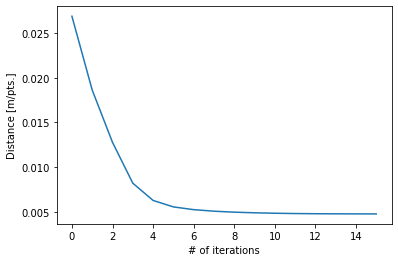

In [28]:
plt.ylabel("Distance [m/pts.]")
plt.xlabel("# of iterations")
plt.plot(reg.d)

ICPアルゴリズムの繰り返し演算は，誤差が単調減少することが保証されています．
グラフから，このことを確認することができました．

最終的な位置合わせ結果の点群は```pcd_reg```です．

In [29]:
pcd_reg.paint_uniform_color([1.0,0.0,0.0])
o3d.visualization.draw_geometries([pcd_t, pcd_reg] )

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


Open3DのICPアルゴリズムと同様に，位置合わせできていることがわかりました．

最後に，各ステップでの位置合わせの様子をアニメーションとして可視化してみましょう．

In [32]:
from icp_registration import visualize_icp_progress
visualize_icp_progress( reg )

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


0.3秒おきに画面が更新されて，徐々に位置合わせされている様子を確認することができました．